## Imports

In [4]:
import preprocessing as prep
import model
from main import *
from tqdm import tqdm
import torch
import torch.utils.data
import os
from torchvision.utils import make_grid
import torch.nn as nn
import torch.optim as optim
from timeit import default_timer as timer
import model
import preprocessing as prep
import argparse
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path
import json

#End - Do not change these!
HYPER_PARAMETER_CONFIG = "../hparams.json"
MODEL_STORAGE="../model_storage"
ROOT="../data"
SEED = 1
PADDING_WORD="<MASK>"
hparams = prep.read_json_config(HYPER_PARAMETER_CONFIG)
hparams["root"]=ROOT
hparams["model_storage"]=MODEL_STORAGE
trainset_name = "train"
valset_name = "val"
testset_name = "test"
#End - Do not change these!

## Parameters to set. Currently configured to load the model file: TODO add the name of the best model file

In [7]:
hparams = {
   # You can configure the following parameters.
   # Currently configured to load ...
   # Changing these parameter can force a new training
   "batch_size": 1,
   "rnn_layers" : 2,
   "shuffle" : True,
   "cnn_model": "resnet50",#values "lstm", "gru", "resnet50"
   "rnn_model": "gru",
   "improve_embedding": True,
   "improve_cnn": False,
   "image_size": 480,# between 256 and 640
   "crop_size": 320,# minimum 224, must be lower than "image_size"
   "caption_number" : 3, #number of captions to use in the dataset. between 1 and 5
   "cutoff": 2, # Minimum word frequency to not flag a word as unknwon
   "clip_grad": None,# set to 1.0 if NaN values appear during training
   "weight_decay": 0.00001, # L2 Regularization
   "num_epochs": 1,
   "lr": 0.001,# learning rate
   "sgd_momentum": None,# 
   "break_training_loop_percentage": 1,
   "drop_out_prob" : 0.2,# only when "rnn_layers" > 1, otherwise set to 0
   "sampling_method": "beam_search",# either "beam_search", "sample_search" or "" for a greedy search
   "beam_width": 3,
   "training_report_frequency" : 5,
   "last_saved_model" : None,
   #Do not change the following parameters
   "use_pixel_normalization" : True,
   "compute_val_loss": True,
   "keep_best_val_loss": False,
   "keep_best_total_loss": True,
   "gold_eval_with_original": True,
   "device": "cuda:0",
   "root": "../data",
   "annotation_without_punctuation": False,
   "train": "train2017",
   "val": "val2017",
   "test": "test2017",
   "timestamp_prefix": "%d%b%Y_%H_%M_%S_%f",
   "debug": False,
   "print_prediction" : False,
   "save_eval_results" : False,
   "model_name": "_.pt",
   "use_glove": True,
   "use_padding_idx": True,
   "model_storage": "./model_storage",
   "glove_embedding": "glove.6B.300d.bin.word2vec",
   "save_pending_model" : False,
   "hidden_dim": 512,
   "embedding_dim" : 300,
   "use_tensorboard":False
}


## Training and evaluation

In [8]:
torch.cuda.empty_cache()

device = hparams["device"]
if not torch.cuda.is_available():
    print("Warning, only CPU processing available!")
    device = "cpu"
else:
    print("CUDA GPU is available", "Number of machines:", torch.cuda.device_count())

#Makes results more reproducible
prep.set_seed_everywhere(SEED)

#Prepare the vectorizer, mapping words to indices and vice versa
cleaned_captions = prep.get_captions(hparams, trainset_name)
cutoff_for_unknown_words = hparams["cutoff"]
c_vectorizer = model.CaptionVectorizer.from_dataframe(cleaned_captions, cutoff_for_unknown_words)


#Creates embedding model
padding_idx = None
if (hparams["use_padding_idx"]):
    padding_idx = c_vectorizer.get_vocab()._token_to_idx[PADDING_WORD]
embedding = model.create_embedding(hparams, c_vectorizer, padding_idx)

#Creates Data loaders
train_loader = model.CocoDatasetWrapper.create_dataloader(hparams, c_vectorizer, trainset_name)
#the pictures for the training set and the test set shares the same directory, "train2017"
test_loader = model.CocoDatasetWrapper.create_dataloader(hparams, c_vectorizer, testset_name, "train2017")
val_loader = model.CocoDatasetWrapper.create_dataloader(hparams, c_vectorizer, valset_name)

#Creates the network
network = model.RNNModel(hparams["hidden_dim"], pretrained_embeddings=embedding,
                         cnn_model=hparams["cnn_model"], rnn_layers=hparams["rnn_layers"],
                         rnn_model=hparams["rnn_model"], drop_out_prob=hparams["drop_out_prob"],
                         improve_cnn=hparams["improve_cnn"]).to(device)

#Either load previous state or starts a training
start_training = init_model(hparams, network, False)
break_training_loop_idx, break_val_loop_idx, break_test_loop_idx = get_stop_loop_indices(hparams, train_loader,
                                                                                         val_loader, test_loader)

#Training
if start_training:
    loss_function = nn.NLLLoss().to(device)
    train(hparams, loss_function, network, train_loader, device, break_training_loop_idx, val_loader)

# Evaluation Part    
#model.BleuScorer.perform_whole_evaluation(hparams, train_loader, network, break_training_loop_idx, "train")
#model.BleuScorer.perform_whole_evaluation(hparams, test_loader, network, break_test_loop_idx, "test")


9it [00:00, 85.94it/s]

CUDA GPU is available Number of machines: 1
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


946it [00:10, 88.25it/s]


Loading glove vectors...
GloVe embedding size: 300
Image dir: ../data\train2017
Caption file path: ../data\annotations\1_cleaned_captions_train2017.json
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Image dir: ../data\train2017
Caption file path: ../data\annotations\1_cleaned_captions_test2017.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Image dir: ../data\val2017
Caption file path: ../data\annotations\1_cleaned_captions_val2017.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Using resnet50...


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Model save path: ./model_storage\lp1_img480_cs320_resnet50_gru_l2_hdim512_emb300_lr0.001_wd1e-05_epo1_bat1_do0.2_cut2_can3_with_norm_ie_s.pt
Start Training


  0%|                                                                                            | 0/1 [00:05<?, ?it/s]


KeyboardInterrupt: 

## Configure data for predictions

In [24]:
from torchvision import transforms
import torchvision.datasets as dset
import matplotlib.pyplot as plt
%matplotlib inline
name="val"
train_file = hparams[name]
image_dir = os.path.join(hparams['root'], train_file)
caption_file_path = prep.get_correct_annotation_file(hparams, name)
device = hparams["device"]
if not torch.cuda.is_available():
    print("Warning, only CPU processing available!")
    device = "cpu"
else:
    print("CUDA GPU is available", "Number of machines:", torch.cuda.device_count())


#START PARAMETERS to adapt if needed
model_to_load="lp1_img480_cs320_resnet50_gru_l2_hdim512_emb300_lr0.001_wd1e-05_epo1_bat8_do0.2_cut2_can3_with_norm_ie_s.pt"
hidden_dim=512
cnn_model="resnet50"
rnn_layers=2
rnn_model="gru"
drop_out_prob=0.2
num_image_to_show=3
#END PARAMETERS to adapt if needed


cleaned_captions = prep.get_captions(hparams, trainset_name)
cutoff_for_unknown_words = hparams["cutoff"]
vectorizer = model.CaptionVectorizer.from_dataframe(cleaned_captions, cutoff_for_unknown_words)
#Creates embedding model
padding_idx = None
if (hparams["use_padding_idx"]):
    padding_idx = vectorizer.get_vocab()._token_to_idx[PADDING_WORD]
embedding = model.create_embedding(hparams, vectorizer, padding_idx)



9it [00:00, 85.13it/s]

CUDA GPU is available Number of machines: 1
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


946it [00:11, 81.34it/s]


Loading glove vectors...
GloVe embedding size: 300


## Predictions...

Using resnet50...
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
50
Prediction: locomotive locomotive helicopter helicopter helicopter grapes rural rural chicken chicken carrot carrot entering pose croquet lies valley next croquet valley next carrot croquet multiple multiple hardwood hardwood bread ramp lounge empty trying apples ramp apples one apples arms apples bite utensils classic classic classic shows classic around classic mostly next next next apples carrot carrot entering ramp ramp one tow tow tow tow they tow classic classic classic classic mostly mostly next next apples carrot carrot entering ramp ramp one tow tow tow tow they tow classic classic classic classic mostly mostly next next apples carrot carrot entering ramp ramp one tow tow tow tow they tow classic classic classic classic mostly mostly next next apples carrot carrot entering ramp ramp one tow to

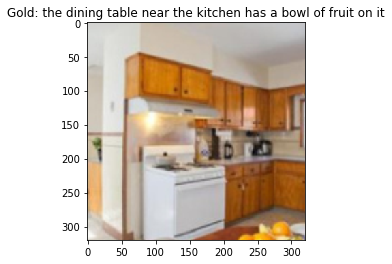

Prediction: locomotive locomotive helicopter helicopter helicopter grapes ramp grapes ramp knife pose towards pose head hardwood empty french french hardwood hardwood bread bread pitcher pitcher pitcher kid around on ramp boys on on helicopter helicopter helicopter grapes ramp ramp tow tow empty ramp bag ramp tow tow empty ramp bag ramp tow tow empty ramp bag ramp tow tow empty ramp bag ramp tow tow empty ramp bag ramp tow tow empty ramp bag ramp tow tow empty ramp bag ramp tow tow empty ramp bag ramp tow tow empty ramp bag ramp tow tow empty ramp bag ramp tow tow empty ramp bag ramp tow tow empty ramp bag ramp tow tow empty ramp bag ramp tow tow empty ramp bag ramp tow tow empty ramp bag ramp tow tow empty ramp bag ramp tow tow empty ramp bag ramp tow tow empty ramp bag ramp tow tow empty ramp bag ramp tow tow empty ramp bag ramp tow tow empty ramp bag ramp tow tow empty ramp bag ramp tow tow empty ramp bag ramp tow tow empty ramp bag ramp tow tow empty ramp bag ramp tow tow empty ram

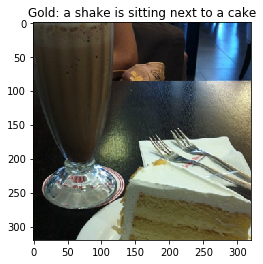

Prediction: mirrors dining trying trying wit apples ramp strong tow tow tow moves narrow next next next next next apples shirt bite apples ramp ramp one apples tow ramp tow tow empty ramp grapes ramp one apples tow ramp tow empty ramp grapes ramp one apples apples engine books engine ramp slopes knife tow tow empty ramp grapes ramp one apples tow ramp tow tow empty ramp grapes ramp one apples tow ramp tow empty ramp grapes ramp one apples apples engine books engine ramp slopes knife tow tow empty ramp grapes ramp one apples tow ramp tow tow empty ramp grapes ramp one apples tow ramp tow empty ramp grapes ramp one apples apples engine books engine ramp slopes knife tow tow empty ramp grapes ramp one apples tow ramp tow tow empty ramp grapes ramp one apples tow ramp tow empty ramp grapes ramp one apples apples engine books engine ramp slopes knife tow tow empty ramp grapes ramp one apples tow ramp tow tow empty ramp grapes ramp one apples tow ramp tow empty ramp grapes ramp one apples ap

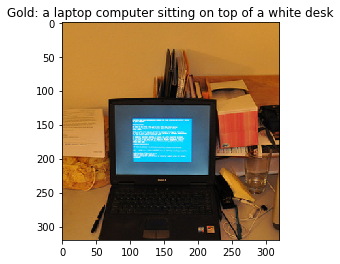

In [22]:
network = model.RNNModel(hidden_dim, pretrained_embeddings=embedding,
                             cnn_model=cnn_model, rnn_layers=rnn_layers,
                             rnn_model=rnn_model, drop_out_prob=drop_out_prob,
                             improve_cnn=False).to(device)
last_model = os.path.join(hparams["root"], model_to_load)
if os.path.isfile(last_model):
    print("Load temporary model: ", last_model)
    network.load_state_dict(torch.load(last_model))
    
transform_without_norm = transforms.Compose([transforms.Resize(hparams["image_size"]),
                                     transforms.CenterCrop(hparams["crop_size"]),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                                    ])
coco_val_t = dset.CocoDetection(root=image_dir,
                                    annFile=caption_file_path,
                                    transform=transform_without_norm
                                    )
#val_loader_no_transform = torch.utils.data.DataLoader(coco_val_t, batch_size=hparams["batch_size"])

transform = transforms.Compose([transforms.Resize(hparams["image_size"]),
                                     transforms.CenterCrop(hparams["crop_size"]),
                                     transforms.ToTensor()
                                    ])
coco_val = dset.CocoDetection(root=image_dir,
                                    annFile=caption_file_path,
                                    transform=transform
                                    )
#val_loader = torch.utils.data.DataLoader(coco_val, batch_size=hparams["batch_size"])

iter_val= iter(coco_val)
iter_val_t= iter(coco_val_t)



for idx in range(num_image_to_show):
    original_img, _ = next(iter_val)
    transformed_img, annotations = next(iter(iter_val_t))
    starting_token = vectorizer.create_starting_sequence().unsqueeze(dim=0).unsqueeze(dim=0).to(device)
    model_input = (transformed_img.unsqueeze(dim=0).to(device),starting_token)
    predicted_label = network.predict_greedy(model_input)
    prediction = vectorizer.decode(predicted_label[0][0])
    print("Prediction:", prediction)
    plt.imshow(original_img.permute(1,2,0))
    plt.title("Gold: "+annotations[0]["caption"])
    plt.show()